# Trabajo practico 1: Clasificiones con Decision Trees y Naive Bayes
### Integrantes: Rodrigo Mauriño, Martin Llada, Juan Jose Iguaran

La base de datos consiste en informacion sobre creditos para vivivienda en el estado de Nueva York, EE.UU. y el objetivo del ejercicio es lograr entrenar modelos clasificatorios que permitan predecir si el aplicante n, dados los valores de los atributos X, es elegible para el credito.  <br> Para proceder a entrenar los modelos clasificatorios, es necesario alistar el framework mediante la importacion de las librerias necesarias:

In [4]:
import os
import pandas as pd 
import numpy as np
import sklearn as sk
import random
from sklearn import model_selection
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB

Una vez importadas las librerias, es necesario importar el dataset a ser utlizado, asi como una pequeña visualizacion del mismo:

In [5]:
data = pd.read_csv("baseclean.csv")
dataf=data.copy()
dataf=dataf.dropna()
dataf.head()

,action_taken,agency_code,applicant_ethnicity,applicant_income_000s,applicant_race_1,applicant_sex,application_date_indicator,census_tract_number,co_applicant_ethnicity,co_applicant_race_1,...,property_type,purchaser_type,sequence_number,hud_median_family_income,loan_amount_000s,number_of_1_to_4_family_units,number_of_owner_occupied_units,minority_population,population,tract_to_msamd_income
0,1,9,3,230.0,6,3,0,319.00,5,8,...,1,0,155085,82700.0,159,2414.0,2077.0,14.770000,7442.0,138.440002
1,1,7,1,66.0,6,1,0,602.02,3,5,...,2,0,37462,95200.0,47,1422.0,1298.0,19.690001,3997.0,85.000000
3,1,5,2,174.0,5,1,0,502.03,2,5,...,1,0,20,95200.0,40,1723.0,1578.0,17.639999,4971.0,119.169998
4,1,9,2,100.0,5,2,0,195.00,5,8,...,1,0,12370,71300.0,378,615.0,738.0,60.779999,3366.0,78.169998
5,1,7,2,155.0,5,1,0,3037.00,2,5,...,1,1,143,109000.0,352,2008.0,2041.0,22.570000,6718.0,87.589996


Puesto que una delas variables, especificamente, el nombre del condado es un string, se procede a realizar una transformacion en numerica mediante label_encoder y luego reemplazar los valores originales por los obtenidos a partir de la transformacion para poder ejecutar el algoritmo. Asi mismo, es necesario transformar la variable objetivo action_taken en binario para poder luego calcular medidas de desempeño, asi que se procede crear una lista que contiene los indices que resultaron en un credito aprobado, para asignar 1 si la entrada esta dentro de los valores de la lista, o 0 en caso contrario::

In [6]:
values = np.array(dataf["county_name"])
integer_encoded = sk.preprocessing.LabelEncoder().fit_transform(values)
dataf.loc[:,"county_name"]=integer_encoded
lista = [1,5,6]
target_encoded =dataf['action_taken'].isin(lista).astype(int)

## 1) Particion de datos
Ahora que los datos se encuentran en un formato apto para el modelo, se procede a ejecutar su particion. Esta particion tendra como varible objetivo la decision tomada, y como parametros las demas columnas. Consistira en un 80% de los datos para desarrollo y en un 20% para test:

In [7]:
X=dataf.iloc[:,1:]
Y=target_encoded
dev_x, test_x, dev_y, test_y = model_selection.train_test_split(X,Y,train_size=0.8, test_size=0.2,random_state=123)

## 2) Arboles de decision

### 2.1) Arbol de altura 3

Con el objetivo de realizar una validacion cruzada que permita calcular las medidas de desempeño tanto para los datos de entrenamiento como para los de validacion, se procede a implementar la funcion cross_val_nuevo(x_set, y_set, n_folds, tree, perf) que tomara como entrada el set de datos, el set de datos a predecir, el numero de particiones, un modelo predictivo y el tipo de medida de desempeño. Tendra como salida dos listas, ambas de longitud del numero de particiones, la primera seran los puntajes para los datos de entrenamiento y la segunda seran los puntajes para los datos de validacion:

In [8]:
def cross_val_nuevo(x_set, y_set, n_folds, model, perf):
    tree = sk.base.clone(model)
    index = random.sample(range(x_set.shape[0]), x_set.shape[0])
    n = int(x_set.shape[0]/n_folds)
    list_x = []
    list_y = []
    train_score = []
    val_score = []
    for i in range(n_folds):
        fold_x = x_set.iloc[index[n*i:n*(i+1)],].copy()
        list_x.append(fold_x)
        fold_y = y_set.iloc[index[n*i:n*(i+1)],].copy()
        list_y.append(fold_y)
    for i in range(n_folds):
        val_x = list_x[i].copy()
        val_y = list_y[i].copy()
        train_x = list_x.copy()
        train_y = list_y.copy()
        del train_x[i]
        del train_y[i]
        x = pd.concat(train_x)
        y = pd.concat(train_y)
        tree.fit(x,y)
        pred_train = tree.predict(x)
        pred_val = tree.predict(val_x)
        if perf == 'acc':
            train_score.append(round(sk.metrics.accuracy_score(y,pred_train), 3))
            val_score.append(round(sk.metrics.accuracy_score(val_y,pred_val), 3))
        elif perf == 'roc':
            train_score.append(round(sk.metrics.roc_auc_score(y,pred_train), 3))
            val_score.append(round(sk.metrics.roc_auc_score(val_y,pred_val), 3))
    return train_score,val_score        

Se procede a crear un objeto tipo DecisionTreeClassifier con altura maxima altura 3 manteniendo el resto de los hiperparametros en su valor preestablecido:

In [9]:
dtree =sk.tree.DecisionTreeClassifier(max_depth = 3)

Una vez creado el objeto, se procede a estimar el desempeño del modelo utilizando 5-fold cross validation a travez de la funcion  cross_val_nuevo utilizando la medida de accuracy:

In [10]:
perf_3tree = cross_val_nuevo(dev_x, dev_y, 5, dtree, 'acc')
perf_3tree

([0.799, 0.781, 0.793, 0.786, 0.792], [0.802, 0.784, 0.764, 0.793, 0.788])

Se puede apreciar que para el arbol entrenado, la precision se encuentra alrededor del 80% aproximadamentepara los datos de entrenamiento. Asi mismo, se evidencia que para los datos de validacion se tiene una medida parecida de performance. Se procede a estimar el desempño sobre el mismo arbol, pero esta vez utilizando roc_auc:

In [12]:
perf_3tree_roc = cross_val_nuevo(dev_x, dev_y, 5, dtree, 'roc')
perf_3tree_roc

([0.785, 0.778, 0.784, 0.736, 0.789], [0.759, 0.787, 0.763, 0.732, 0.727])

Los resultados obtenidos utilizando esta medida son parecidos a lo obtenidos utilizando accuracy, aunque se puede apreciar que son levemente inferiores. A continuacion se calcularan las medias y los desvios estandar para todos las medidas de performance, para ello, primero se transformaran las listas en un arreglo de numpy:

In [13]:
train_acc = np.array(perf_3tree[0])
val_acc = np.array(perf_3tree[1])
train_roc = np.array(perf_3tree_roc[0])
val_roc = np.array(perf_3tree_roc[1])
print(round(train_acc.mean(),3))
print(round(train_acc.std(),3))
print(round(val_acc.mean(),3))
print(round(val_acc.std(),3))
print(round(train_roc.mean(),3))
print(round(train_roc.std(),3))
print(round(val_roc.mean(),3))
print(round(val_roc.std(),3))

0.79
0.006
0.786
0.013
0.774
0.02
0.754
0.022


Se puede apreciar que para ambas medidas, la media es mas alta y la desviacion estandar mas baja para los datos de entrenamiento, lo que es consecuente pues el modelo se comporta mejor para los datos con los que fue entrenado. Por otro lado, tambien se evidencia que la medida de acucracy es significativamente mejor en todos los casos que el roc_auc.

### 2.2) Arboles de diferentes combinaciones


Con el objetivo de tener una comparacion de desempeño al variar los hiperparametros, se procede a crear un nuevo arbol de la misma profundidad, pero esta vez utilizando como criterio information gane en lugar de Gini:

In [10]:
dtree_ig= sk.tree.DecisionTreeClassifier(criterion = 'entropy',max_depth = 3)

Con el nuevo arbol, se calcularan las mismas metricas obtenidas anteriormente:

In [11]:
acc_results_ig = cross_val_nuevo(dev_x, dev_y, 5, dtree_ig, 'acc')
roc_results_ig = cross_val_nuevo(dev_x, dev_y, 5, dtree_ig, 'roc')
print(acc_results_ig)
print(roc_results_ig)

([0.814, 0.788, 0.782, 0.79, 0.779], [0.781, 0.757, 0.797, 0.777, 0.793])
([0.73, 0.795, 0.782, 0.777, 0.705], [0.747, 0.767, 0.777, 0.797, 0.635])


No se evidencia una diferencia significativa entre las medidas obtenidas a partir de la utiliacion de infromation gane. A continuacion se crearan dos arboles utilizando ambos criterios pero esta vez, con una altura de 6:

In [12]:
dtree_6_gn= sk.tree.DecisionTreeClassifier(max_depth = 6)
dtree_6_ig= sk.tree.DecisionTreeClassifier(criterion = 'entropy',max_depth = 6)

Se calcularan ahora las metricas de costumbre, iniciando con el arbol creado utilizando GINI:

In [13]:
acc_results_6 = cross_val_nuevo(dev_x, dev_y, 5, dtree_6_gn, 'acc')
roc_results_6 = cross_val_nuevo(dev_x, dev_y, 5, dtree_6_gn, 'roc')
print(acc_results_6)
print(roc_results_6)

([0.848, 0.862, 0.859, 0.851, 0.853], [0.82, 0.761, 0.804, 0.82, 0.826])
([0.859, 0.817, 0.851, 0.842, 0.85], [0.79, 0.768, 0.812, 0.778, 0.777])


Es apreciable la mejora en el desempeño para todas las metricas estudiadas, por lo que es concluible que un arbol de profundidad 6 se ajusta mejor al dataset en cuestion. Ahora se calcularan las mismas metricas para el arbol entrenado a partir de information gane:

In [14]:
acc_results_6_ig = cross_val_nuevo(dev_x, dev_y, 5, dtree_6_ig, 'acc')
roc_results_6_ig = cross_val_nuevo(dev_x, dev_y, 5, dtree_6_ig, 'roc')
print(acc_results_6_ig)
print(roc_results_6_ig)

([0.84, 0.847, 0.855, 0.84, 0.841], [0.815, 0.822, 0.808, 0.817, 0.822])
([0.839, 0.821, 0.831, 0.818, 0.815], [0.808, 0.784, 0.802, 0.778, 0.792])


Se puede evidenciar como las metricas son bastante similares a las observadas con la utilizacion de GINI, sin embargo, aunque algunas tuvieron mejor desempeño, puede decirse que hay una leve mejoria con GINI. Ahora se creara un arbol sin ninguna especificacion de altura maxima para ambos criterios:

In [15]:
dtree_max_gn= sk.tree.DecisionTreeClassifier()
dtree_max_ig= sk.tree.DecisionTreeClassifier(criterion = 'entropy')

De la misma manera que para el arbol anterior, se calcularan las metricas de costumbre utilizando GINI:

In [16]:
acc_results_max = cross_val_nuevo(dev_x, dev_y, 5, dtree_max_gn, 'acc')
roc_results_max = cross_val_nuevo(dev_x, dev_y, 5, dtree_max_gn, 'roc')
print(acc_results_max)
print(roc_results_max)

([1.0, 1.0, 1.0, 1.0, 1.0], [0.779, 0.766, 0.791, 0.764, 0.766])
([1.0, 1.0, 1.0, 1.0, 1.0], [0.736, 0.759, 0.764, 0.714, 0.757])


Resalta el hecho de que al no especificar la profundidad, el modelo incurre en overfitting, pues predeice de manera exacta para los datos de entrenamiento enn ambas medidas, sin embargo, los puntajes para los datos de validacion son menores que los obtenidos para los arboles anteriores, por lo que pierde capacidad de prediccion.

## 2.3) Tratamiento de datos faltantes

Para evaluar la influencia de la cantidad de datos faltantes en un data set, y la estrategia de relleno que se implemente, a continuacion se implementa la funcion outliers(data,clase, index, por, rell), que recibira el set de datos asi como la variable a predecir, el indice del atributo a modificar, un porcentaje de datos faltantes y una estrategia de de relleno que podra ser moda o clase modal, y devolvera como salida un nuevo data frame que tendra el porcentaje de datos faltantes rellenados con la estrategia de relleno:

In [17]:
def outliers(data,clase,index, por, rell):
    new = data.copy()
    n = int(new.shape[0]*(por/100))
    rand = random.sample(range(new.shape[0]), n) 
    for i in rand:
        new.iloc[i,index] = np.nan
    if rell == 'mode':
        mode = int(new.iloc[:,index].mode())
        for i in rand:
            new.iloc[i,index] = mode
    elif rell == 'class_mode':
        feat = new.iloc[:,index]
        for i in rand:
            mode = int(feat[clase == clase.iloc[i]].mode())
            new.iloc[i,index] = mode
    return new

Para las siguientes evaluaciones se utilizara el 80% de los datos de desarrollo, pues el otro 20% sera empleado en validacion:

In [18]:
des_x, val_x, des_y, val_y = model_selection.train_test_split(dev_x,dev_y,train_size=0.8, test_size=0.2,random_state=123)

Con lo observado anteriormente a partir de las metricas, se puede concluir que de los arboles previamente evaluados, aquel que tuvo mejor desempeño fue el construido a partir de GINI con una profundidad maxima de 6, por lo que para los siguientes analisis se utilizara dicha configuracion. Para evaluar la influencia de los datos faltantes, el proceso sera mas notorio si estos datos faltan en el atrbuto mas relevante, por lo que a continuacion se creara y entrenara un arbol con las caracteristicas previamente mencionadas para obtener el indice de dicho atributo:

In [19]:
opt_tree= sk.tree.DecisionTreeClassifier(max_depth = 6)
opt_tree.fit(des_x,des_y)
importance = opt_tree.feature_importances_
index = np.argmax(importance)
print(index)

20


### 2.3 a) Ejecucion en distintos datasets

Conociendo cual es el indice del atributo mas importante se procedera a generar una lista de datasets con diferentes cantidades de datos faltantes, desde 0 a 80% variando en intervalos de 5%, tanto para el metodo de modas como para el de modas de clase, para evaluar el desempeño de arboles entrenados con cada uno de estos datasets:

In [20]:
list_mode = []
list_class_mode = []
list_mode.append(des_x.copy())
list_class_mode.append(des_x.copy())
for i in range(5,85,5):
    list_mode.append(outliers(des_x,des_y,index, i, 'mode'))    
    list_class_mode.append(outliers(des_x,des_y,index, i, 'class_mode'))

Una vez creados los datasets, se procede a entrenar modelos con ellos para calcular el tamaño y el performance de cada uno para poder compararlos segun estas medidas:

In [21]:
tree_size_mode = []
acc_mode = []
tree_size_class_mode = []
acc_class_mode =[]
for i in range(len(list_mode)):
    tree_mode = sk.tree.DecisionTreeClassifier(max_depth = 6)
    tree_mode.fit(list_mode[i],des_y)
    tree_size_mode.append(tree_mode.tree_.node_count)
    pred_mode = tree_mode.predict(val_x)
    acc_mode.append(sk.metrics.accuracy_score(val_y,pred_mode))
    tree_class_mode = sk.tree.DecisionTreeClassifier(max_depth = 6)
    tree_class_mode.fit(list_class_mode[i],des_y)
    tree_size_class_mode.append(tree_class_mode.tree_.node_count)
    pred_class_mode = tree_class_mode.predict(val_x)
    acc_class_mode.append(sk.metrics.accuracy_score(val_y,pred_class_mode)) 

### 2.3 b) Tamaño del arbol vs porcentaje de faltantes

A continuacion se realizan las graficas del tamaño del arbol en funcion del porcentaje de faltantes tanto para los reemplazados por modo, como por clase modal, para poder pareciar el comportamiento:

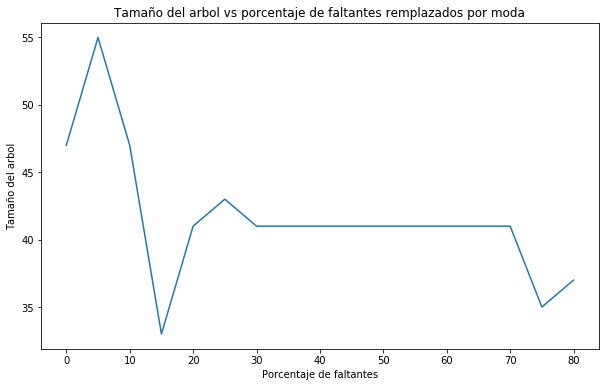

In [22]:
plt.figure(figsize=(10,6))
plt.plot(list(range(0,85,5)), tree_size_mode)
plt.title('Tamaño del arbol vs porcentaje de faltantes remplazados por moda')
plt.ylabel('Tamaño del arbol')
plt.xlabel('Porcentaje de faltantes')
plt.show()

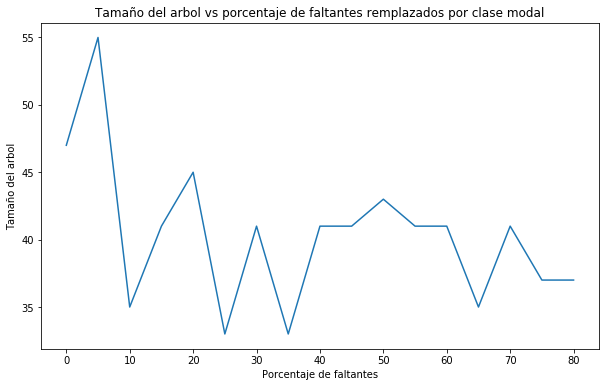

In [23]:
plt.figure(figsize=(10,6))
plt.plot(list(range(0,85,5)), tree_size_class_mode)
plt.title('Tamaño del arbol vs porcentaje de faltantes remplazados por clase modal')
plt.ylabel('Tamaño del arbol')
plt.xlabel('Porcentaje de faltantes')
plt.show()

Aun cuando existen leves diferencias entre las graficas, se puede concluir que obedecen a la misma tendencia: a mayor porcentaje de faltantes disminuye el tamaño del arbol. 

### 2.3 c) Performance vs porcentaje de faltantes

De igual manera, se realizan las graficas del performance en funcion del porcentaje de faltantes tanto para los reemplazados por modo, como por clase modal, para poder pareciar el comportamiento:

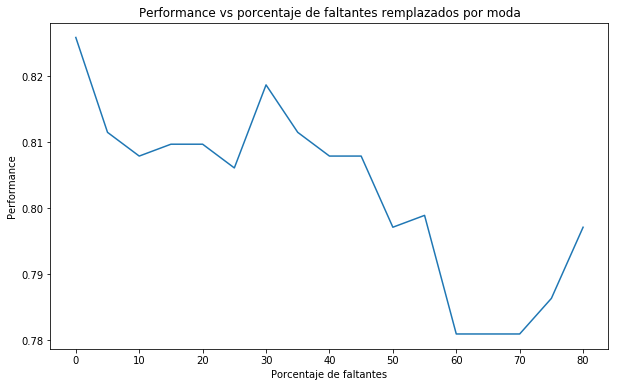

In [24]:
plt.figure(figsize=(10,6))
plt.plot(list(range(0,85,5)), acc_mode)
plt.title('Performance vs porcentaje de faltantes remplazados por moda')
plt.ylabel('Performance')
plt.xlabel('Porcentaje de faltantes')
plt.show()

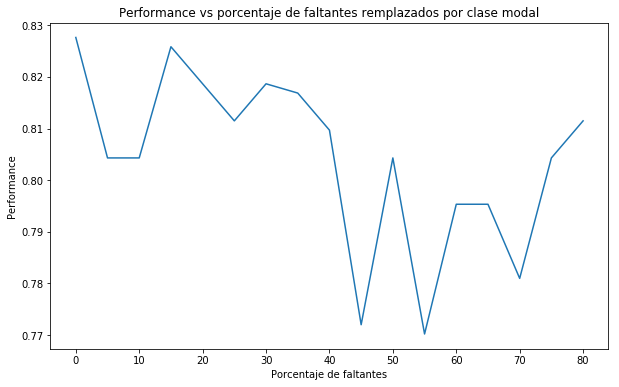

In [25]:
plt.figure(figsize=(10,6))
plt.plot(list(range(0,85,5)), acc_class_mode)
plt.title('Performance vs porcentaje de faltantes remplazados por clase modal')
plt.ylabel('Performance')
plt.xlabel('Porcentaje de faltantes')
plt.show()

Al igual que con el tamaño del arbol,aun cuando existen leves diferencias entre las graficas, se puede concluir que obedecen a la misma tendencia: a mayor porcentaje de faltantes disminuye el performance.

###  2.3 d) Analisis

Los comportamientos de las graficas anteriores apuntan en la misma direccion: el arbol disminuye su capacidad para generar caminos exitosos con el incremento de ruido y por consiguiente su capacidad predecir. A pesar de ligeras diferencias, el comportamiento de ambas estrategias de relleno es bastante similar, asi que puede concluirse que es indistinto utilizar alguna de estas para el tratamiento de outliers.

## 4) Tolerancia al ruido.
Para evaluar la influencia del ruido -cambios en los datos- sobre un atributo numero de un data set, a continacuion se implementa la funcion ind_ruido(data, index, porcentaje), que recibira el set de datos, el indice del atributo a modificar y un porcenatje de datos con ruido, y dicha funcion devolvera como slaida un nuevo data frame que tendra el porcentaje de datos con ruido:    

In [27]:
def ind_ruido(data,index,porcentaje):
    new=data.copy()
    n=int(new.shape[0]*(porcentaje/100))
    rand=random.sample(range(new.shape[0]),n)
    for i in rand:
        noise = np.random.normal(new.iloc[:,index].mean(),new.iloc[:,index].mean()+1000000,1)
        valor=(new.iloc[i,index])+noise
        new.iloc[i,index]=valor
    return new

Para las siguientes evaluaciones se utilizara el 80% de los datos de desarrollo, ya que el otro 20% sera empleado en validacion.

In [15]:
des_x, val_x, des_y, val_y = model_selection.train_test_split(dev_x,dev_y,train_size=0.8, test_size=0.2,random_state=123)

Con lo observado anteriormente a partir de las metricas, se puede concluir que de los arboles previamente evaluados, aquel que tuvo mejor desempeño fue el construido a partir de GINI con una profundidad maxima de 6, por lo que para los siguientes analisis se utilizara dicha configuracion. Para evaluar la influencia del ruido en los datos, el proceso sera mas notorio si estos datos se encuentran en el atrbuto mas relevante, por lo que a continuacion se creara y entrenara un arbol con las caracteristicas previamente mencionadas para obtener el indice de dicho atributo:

In [22]:
opt_tree= sk.tree.DecisionTreeClassifier(max_depth = 6)
opt_tree.fit(des_x,des_y)
importance = opt_tree.feature_importances_
index = np.argmax(importance)
print(index)

20


### 4.1) Ejecucion en diferentes datasets
Conociendo cual es el indice del atributo mas importante se procederá a generar una lista de datasets con diferentes cantidades de ruido, desde 0 a 35%, variando en intervalos de 5%. Luego se evaluará el desempeño de arboles entrenados con cada uno de estos datasets.

In [39]:
lista= []
lista.append(des_x.copy())
for z in range(0,35,5):
    a = ind_ruido(des_x,index,z)
    lista.append(a)

In [ ]:
len(lista)

Una vez creados los datasets, se procede a entrenar modelos con ellos en pos de calcular el tamaño y la perfomance de cada uno para poder comprarlos segun dichas metricas.

In [ ]:
noise = np.random.normal(des_x.iloc[:,index].mean(),des_x.iloc[:,index].mean()+100000,1)
print(noise)
print(des_x.iloc[:,index].mean())
print(lista[0].iloc[:,index].mean())
print(lista[1].iloc[:,index].mean())
print(lista[2].iloc[:,index].mean())
print(lista[3].iloc[:,index].mean())
print(lista[0].iloc[:,index].std())
print(lista[1].iloc[:,index].std())
print(lista[2].iloc[:,index].std())
print(lista[3].iloc[:,index].std())

### 4.2) Tamaño del arbol vs porcentaje de ruido
A continuacion se realizan las graficas del tamaño del arbol en funcion del porcentaje de ruido, en pos de apreciar el comportamiento:

In [ ]:
tree_size_noyse = []
acc_noyse = []
for i in range(len(lista)):
    tree_noyse = sk.tree.DecisionTreeClassifier(max_depth = 6)
    tree_noyse.fit(lista[i],des_y)
    tree_size_noyse.append(tree_noyse.tree_.node_count)
    pred_noyse = tree_noyse.predict(val_x)
    acc_noyse.append(sk.metrics.accuracy_score(val_y,pred_noyse))

    

In [68]:
tree_size_noyse

[47, 47, 73, 77, 61, 87, 77, 77]

In [69]:
acc_noyse

[0.822262118491921,
 0.8276481149012568,
 0.7953321364452424,
 0.8096947935368043,
 0.7917414721723519,
 0.8061041292639138,
 0.8025134649910234,
 0.7827648114901257]

### 4.3) Perfomance vs porcentaje de ruido
De igual manera, se realiza el grafico de la perfomance en funcion del porcentaje del ruido, en pos de apreciar el comportamiento:

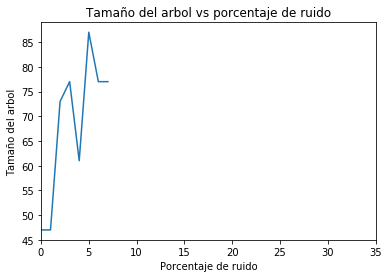

In [66]:
plt.figure(figsize=(10,6))
#plt.plot(list(range(0,35,5)), tree_size_noyse)
plt.plot(tree_size_noyse)
#plt.plot(list(rango), tree_size_noyse)
plt.title('Tamaño del arbol vs porcentaje de ruido')
plt.ylabel('Tamaño del arbol')
plt.xlabel('Porcentaje de ruido')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(list(range(0,35,5)), acc_noyse)
plt.title('Performance vs porcentaje del ruido')
plt.ylabel('Performance')
plt.xlabel('Porcentaje de ruido')
plt.show()

### 4.4) Análisis
Como se puede apreciar en los graficos expuestos en los incisos 4.2 y 4.3, conforme aumenta el ruido en el atributo mas importante, aumenta el temaño del arbol denotando una relacion directa entre estas dos variables. A si mismo, se puede apreciar que incluso cuando el porcteaje de ruido en el atributo mas importante se incrementa, la perfomance del algoritmo,y por lo tanto, su capacidad de prediccion, se mantiene en niveles del orden del 78%.

## 3) Naive Bayes

Al ser Naive Bayes otro de los algoritmos utilizados con frecuencia para los problemas de clasificacion, se procede a implementarlo para comparar su comportamiento con el obtenido a partir de los arboles de decision. A continuacion se crearan distintos objetos naive_bayes que obedecen a distintas distribuciones de probabilidad y se aplicara la funcion previamente implementada para hacer cross validations con el objetivo de escoger la distribucion que mejor se ajuste a los datos: 

In [51]:
bayes_bern = sk.naive_bayes.BernoulliNB()
bayes_compl = sk.naive_bayes.ComplementNB()
bayes_mult = sk.naive_bayes.MultinomialNB()
bayes_gau= sk.naive_bayes.GaussianNB()
list_bayes = [bayes_bern, bayes_compl, bayes_mult, bayes_gau]
for i in list_bayes:
    print(cross_val_nuevo(dev_x, dev_y, 5, i, 'roc'))

([0.826, 0.822, 0.823, 0.817, 0.815], [0.801, 0.814, 0.81, 0.835, 0.843])
([0.48, 0.491, 0.502, 0.497, 0.496], [0.546, 0.503, 0.46, 0.48, 0.481])
([0.495, 0.49, 0.492, 0.492, 0.5], [0.487, 0.506, 0.505, 0.504, 0.466])
([0.539, 0.518, 0.508, 0.537, 0.584], [0.545, 0.507, 0.496, 0.524, 0.527])


A travez de las evaluaciones, se puede concluir que la mejor distribucion es la de bernoulli, lo que tendria sentido pues el atributo a predecir es binario. A continuacion se procede a entrenar un arbol del tipo bernoulli y a informar sus probabilidades previas y condicionales:

In [27]:
bayes_bern.fit(dev_x,dev_y)
prob_prev = np.exp(bayes_bern.class_log_prior_)
print(prob_prev)
prob_feat = np.exp(bayes_bern.feature_log_prob_)
print(prob_feat)

[0.32386772 0.67613228]
[[0.99889258 0.99889258 0.99889258 0.99889258 0.99889258 0.00110742
  0.99889258 0.99889258 0.99889258 0.99889258 0.99889258 0.96899225
  0.99889258 0.99889258 0.99889258 0.99889258 0.99889258 0.99889258
  0.99889258 0.99889258 0.00110742 0.99889258 0.99889258 0.99889258
  0.99889258 0.99889258 0.99889258 0.99889258 0.99889258]
 [0.99946893 0.99946893 0.99946893 0.99946893 0.99946893 0.11949018
  0.99946893 0.99946893 0.99946893 0.99946893 0.99946893 0.9755709
  0.99946893 0.99946893 0.99946893 0.99946893 0.99946893 0.99946893
  0.99946893 0.99946893 0.62506638 0.99946893 0.99946893 0.99946893
  0.99946893 0.99946893 0.99946893 0.99946893 0.99946893]]


## 4) Comparacion de algoritmos

Ahora que conocemos el desempeño de ambos algoritmos, se pocedera a realizar una evualuacion y comparacion de estos utilizando los datos de testeo. Inicialmente debemos crear y entrenar el modelo de mejor desempeño en cada caso utilizando el set de entrenamiento. En el caso de arboles de decision, para encontrar los parametro de dicho arbol se empleara GridSearchCV:

In [34]:
param = {'max_depth': np.arange(1, 30),'criterion' : ('entropy','gini')}
tree = sk.model_selection.GridSearchCV(sk.tree.DecisionTreeClassifier(), param)
tree.fit(dev_x, dev_y)
tree.best_params_

/home/juan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'entropy', 'max_depth': 6}

Tal como el analisis previo lo habia mostrado, la mejor profundiad es 6 y al mejor metodo es entropy. Puesto que previamente se demostro que el mejor tipo de naive bayes es el de la distribucion bernoulli, se utilizara este modelo y el arbol con los hiperparametros encontrados para realizar las validaciones correspondientes utilizando ROC AUC comomtrica, asi como calcular las medias y los desvios de los resultados para volverlos comparables:

In [57]:
tree = sk.tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 6)
bayes = sk.naive_bayes.BernoulliNB()
tree_scores = cross_val_nuevo(dev_x, dev_y, 5, tree, 'roc')
bayes_scores = cross_val_nuevo(dev_x, dev_y, 5, bayes, 'roc')
tree_means = [np.array(tree_scores[0]).mean(),np.array(tree_scores[1]).mean()]
tree_sd = [np.array(tree_scores[0]).std(),np.array(tree_scores[1]).std()]
bayes_means = [np.array(bayes_scores[0]).mean(),np.array(bayes_scores[1]).mean()]
bayes_sd = [np.array(bayes_scores[0]).std(),np.array(bayes_scores[1]).std()]
print(tree_means, tree_sd,'\n', bayes_means, bayes_sd)

[0.828, 0.7914000000000001] [0.004335896677735764, 0.023474241201793932] 
 [0.8204, 0.8203999999999999] [0.0016248076809271936, 0.006711184694224975]


Es apreciable que ambos modelos presentan buenas medidas de desempeño, pero aun cuando el comportamiento para los casos de entrenamiento es bastante parecido, se puede avidenciar que para los casos de validacion el algoritmo de naive_bayes tiene una media mas alta y un menor desvio. A continuacion se procede entrenar los modelos ya evaluar su desempeño con set de testeo:

In [58]:
tree.fit(dev_x, dev_y)
tree_pred = tree.predict(test_x)
bayes.fit(dev_x, dev_y)
bayes_pred = bayes.predict(test_x)
perf_tree = sk.metrics.roc_auc_score(test_y,tree_pred)
perf_bayes = sk.metrics.roc_auc_score(test_y,bayes_pred)
print(perf_tree,perf_bayes)

0.8060438755069136 0.8154639175257732


Tal y como se esperaba, ambas modelos tuvieron buenas medidas de desempeño, siendo la obtenida por naive bayes mejor que aquella del arbol de decision.